In [1]:
# Import dependencies
# Database Dependencies
import pymongo
import gridfs
import pandas as pd
import io
import numpy as np
from PIL import Image, ImageOps
import subprocess
from config import DB_NAME, FEAT_3_COLLECTION_NAME, FEAT_30_COLLECTION_NAME
import seaborn as sns
# Machine Learning Dependencies
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics
import matplotlib.pyplot as plt

# Neural Network Dependencies
import tensorflow as tf
from tensorflow import keras

# Database Connection and Loading Data

In [2]:
# Establish mongo instance and get Music database
client = pymongo.MongoClient('localhost')
db = client[DB_NAME]
db.collection_names()

C:\Users\Eric\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: collection_names is deprecated. Use list_collection_names instead.
  after removing the cwd from sys.path.


['feat_30', 'fs.files', 'fs.chunks', 'feat_3']

In [3]:
# Select 'features_3_sec' collection, and read in as pandas DataFrame
collection = db[FEAT_3_COLLECTION_NAME].find()
features_3_df = pd.DataFrame(list(collection))

# Drop mongo generated hash-code id column
features_3_df = features_3_df.drop(columns = ["_id"])
features_3_df

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9985,rock.00099.5.wav,66149,0.349126,0.080515,0.050019,0.000097,1499.083005,164266.886443,1718.707215,85931.574523,...,42.485981,-9.094270,38.326839,-4.246976,31.049839,-5.625813,48.804092,1.818823,38.966969,rock
9986,rock.00099.6.wav,66149,0.372564,0.082626,0.057897,0.000088,1847.965128,281054.935973,1906.468492,99727.037054,...,32.415203,-12.375726,66.418587,-3.081278,54.414265,-11.960546,63.452255,0.428857,18.697033,rock
9987,rock.00099.7.wav,66149,0.347481,0.089019,0.052403,0.000701,1346.157659,662956.246325,1561.859087,138762.841945,...,78.228149,-2.524483,21.778994,4.809936,25.980829,1.775686,48.582378,-0.299545,41.586990,rock
9988,rock.00099.8.wav,66149,0.387527,0.084815,0.066430,0.000320,2084.515327,203891.039161,2018.366254,22860.992562,...,28.323744,-5.363541,17.209942,6.462601,21.442928,2.354765,24.843613,0.675824,12.787750,rock


In [4]:
# Select 'features_3_sec' collection, and read in as pandas DataFrame
collection = db[FEAT_30_COLLECTION_NAME].find()
features_30_df = pd.DataFrame(list(collection))

# Drop mongo generated hash-code id column
features_30_df = features_30_df.drop(columns = ["_id"])
features_30_df

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
1,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,rock.00095.wav,661794,0.352063,0.080487,0.079486,0.000345,2008.149458,282174.689224,2106.541053,88609.749506,...,45.050526,-13.289984,41.754955,2.484145,36.778877,-6.713265,54.866825,-1.193787,49.950665,rock
996,rock.00096.wav,661794,0.398687,0.075086,0.076458,0.000588,2006.843354,182114.709510,2068.942009,82426.016726,...,33.851742,-10.848309,39.395096,1.881229,32.010040,-7.461491,39.196327,-2.795338,31.773624,rock
997,rock.00097.wav,661794,0.432142,0.075268,0.081651,0.000322,2077.526598,231657.968040,1927.293153,74717.124394,...,33.597008,-12.845291,36.367264,3.440978,36.001110,-12.588070,42.502201,-2.106337,29.865515,rock
998,rock.00098.wav,661794,0.362485,0.091506,0.083860,0.001211,1398.699344,240318.731073,1818.450280,109090.207161,...,46.324894,-4.416050,43.583942,1.556207,34.331261,-5.041897,47.227180,-3.590644,41.299088,rock


In [5]:
cwd_bytes = subprocess.check_output("pwd")
cwd = cwd_bytes.decode("utf-8").rstrip("\n") + "/"

In [6]:
# identify path for images
images_path = "Data/images_original/"

In [7]:
byte_images = subprocess.check_output(["ls", cwd + images_path])
images_folder = byte_images.decode("utf-8").split("\n")
images_folder.pop(-1)

''

In [8]:
# Establish the gridfs instance
fs = gridfs.GridFS(db)

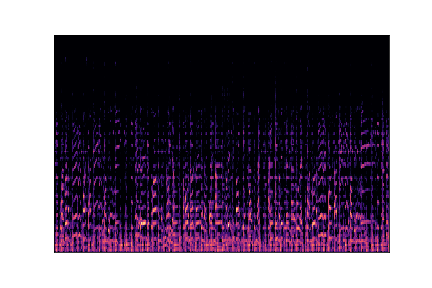

In [9]:
# Single Image Test
test_raw = fs.get_last_version("Data/images_original/blues/blues00000.png")
test_bytes = test_raw.read()
rgba_test = Image.open(io.BytesIO(test_bytes))
# RGBA Image (default)
rgba_test

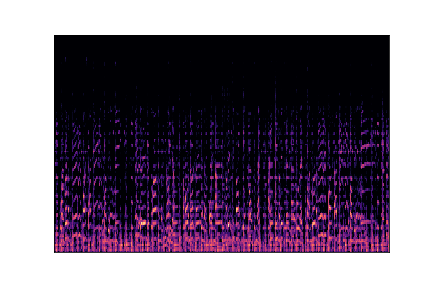

In [10]:
# Converting RGBA TO RGB
rgb_test = rgba_test.convert("RGB")
rgb_test

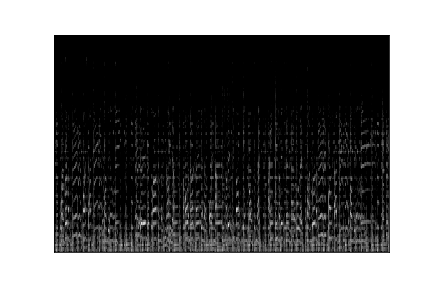

In [11]:
# Converting RGB to Grayscale
gray_test = ImageOps.grayscale(rgb_test)
gray_test

In [12]:
# Convert image to numpy array with pixel values
np.asarray(gray_test)

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [13]:
# Replicate single image loading/conversion to grayscale for all images
images = []
genres = []

for folder in images_folder:
    # Get files in each image-genre folder
    byte_files = subprocess.check_output(["ls", cwd + images_path + folder])
    files = byte_files.decode("utf-8").split("\n")
    files.pop(-1)
    
    for file in files:
        # Load image using its relative path as its GridFS identifier
        file_path = images_path + folder + "/" + file
        image_raw = fs.get_last_version(file_path)
        image_bytes = image_raw.read()
        rgba_image = Image.open(io.BytesIO(image_bytes))
        rgb_image = rgba_image.convert("RGB")
        gray_image = ImageOps.grayscale(rgb_image)
        image_data = np.asarray(gray_image)
        images.append(image_data)
        genres.append(folder)

In [14]:
# Convert image/genre lists to numpy arrays
images = np.asarray(images)
genres = np.asarray(genres)

In [15]:
print(images.shape)
print(genres.shape)

(999, 288, 432)
(999,)


In [16]:
images[0].shape

(288, 432)

In [17]:
genres[0]

'blues'

# Build, Train, and Test Models to Predict `label` from feature data

## `DecisionTreeClassifier`

In [18]:
# Separate Features (X) from the Target (y)
y = features_3_df["label"]
X = features_3_df.drop(columns="label", axis=1)

In [19]:
# Drop `filename` (identifier/same as `label`) and `length` (same for all songs - 3 sec sample)
# from features X
X = X.drop(columns=["filename", "length"], axis=1)
X

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,3714.560359,1.080790e+06,...,-2.853603,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767
1,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,3869.682242,6.722448e+05,...,4.074709,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081
2,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,3997.639160,7.907127e+05,...,4.806280,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122
3,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,3568.300218,9.216524e+05,...,-1.359111,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678
4,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,3469.992864,6.102111e+05,...,2.092937,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9985,0.349126,0.080515,0.050019,0.000097,1499.083005,164266.886443,1718.707215,85931.574523,3015.559458,8.479527e+05,...,5.773784,42.485981,-9.094270,38.326839,-4.246976,31.049839,-5.625813,48.804092,1.818823,38.966969
9986,0.372564,0.082626,0.057897,0.000088,1847.965128,281054.935973,1906.468492,99727.037054,3746.694524,1.170890e+06,...,2.074155,32.415203,-12.375726,66.418587,-3.081278,54.414265,-11.960546,63.452255,0.428857,18.697033
9987,0.347481,0.089019,0.052403,0.000701,1346.157659,662956.246325,1561.859087,138762.841945,2442.362154,2.602871e+06,...,-1.005473,78.228149,-2.524483,21.778994,4.809936,25.980829,1.775686,48.582378,-0.299545,41.586990
9988,0.387527,0.084815,0.066430,0.000320,2084.515327,203891.039161,2018.366254,22860.992562,4313.266226,4.968878e+05,...,4.123402,28.323744,-5.363541,17.209942,6.462601,21.442928,2.354765,24.843613,0.675824,12.787750


In [20]:
# Encode class labels in target y
genre_nums = {}
cnt = 0
for genre in y.unique():
    genre_nums[genre] = cnt
    cnt += 1

y = y.apply(lambda x: genre_nums[x])
genre_nums

{'blues': 0,
 'classical': 1,
 'country': 2,
 'disco': 3,
 'hiphop': 4,
 'jazz': 5,
 'metal': 6,
 'pop': 7,
 'reggae': 8,
 'rock': 9}

In [21]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [22]:
# Instantitae DecisionTreeClassifier
tree_model = DecisionTreeClassifier()

# Fit the model
tree_model = tree_model.fit(X_train, y_train)

# Make predictions using the testing data
tree_pred = tree_model.predict(X_test)
results = pd.DataFrame({
    "Prediction": tree_pred,
    "Actual": y_test
}).reset_index(drop=True)
results

,Prediction,Actual
0,8,8
1,8,8
2,9,9
3,4,0
4,6,9
...,...,...
2493,1,1
2494,8,3
2495,9,2
2496,0,0


In [23]:
# Evaluate model
cm = sklearn.metrics.confusion_matrix(y_test, tree_pred)
cm

array([[148,   2,  24,  15,   9,  14,   7,   0,   9,   8],
       [  1, 215,   4,   0,   5,  15,   2,   0,   3,   2],
       [ 25,  10, 132,  12,  10,  23,   3,   3,  16,  29],
       [ 12,   0,  11, 131,  15,   2,   4,  10,  20,  24],
       [  6,   0,   5,  20, 162,   1,   5,  22,  29,  12],
       [ 15,  18,  10,   8,   5, 166,   4,   2,   8,  15],
       [ 13,   1,   3,  11,  14,   3, 194,   0,   1,  19],
       [  0,   2,   9,  17,  10,   7,   1, 166,  19,  11],
       [ 11,   3,  13,  10,  17,   4,   1,  15, 183,   8],
       [ 17,   9,  26,  20,   6,  17,  20,   8,  14, 107]], dtype=int64)

In [24]:
# Calculate Accuracy Score
acc_score = sklearn.metrics.accuracy_score(y_test, tree_pred)
acc_score

0.6421136909527622

In [25]:
# Print classification report
print(sklearn.metrics.classification_report(y_test, tree_pred))

              precision    recall  f1-score   support

           0       0.60      0.63      0.61       236
           1       0.83      0.87      0.85       247
           2       0.56      0.50      0.53       263
           3       0.54      0.57      0.55       229
           4       0.64      0.62      0.63       262
           5       0.66      0.66      0.66       251
           6       0.80      0.75      0.78       259
           7       0.73      0.69      0.71       242
           8       0.61      0.69      0.65       265
           9       0.46      0.44      0.45       244

    accuracy                           0.64      2498
   macro avg       0.64      0.64      0.64      2498
weighted avg       0.64      0.64      0.64      2498



## `KNN`

In [26]:
# Instantiate SVM
knn_model = KNeighborsClassifier(n_neighbors=21)

# Fit the model
knn_model = knn_model.fit(X_train, y_train)

# Make predicitions using the testing data
knn_pred = knn_model.predict(X_test)
results = pd.DataFrame({
    "Prediction": knn_pred,
    "Actual": y_test
}).reset_index(drop=True)
results

,Prediction,Actual
0,9,8
1,1,8
2,3,9
3,6,0
4,6,9
...,...,...
2493,1,1
2494,2,3
2495,5,2
2496,9,0


In [27]:
# Evaluate model
cm = sklearn.metrics.confusion_matrix(y_test, knn_pred)
cm

array([[ 35,  14,  25,  23,  20,  43,  41,   7,  12,  16],
       [  9, 169,   7,   1,   0,  17,  38,   0,   4,   2],
       [ 16,  18,  54,  42,  12,  29,  29,  15,  31,  17],
       [ 27,   0,  23,  52,  34,   5,  20,  21,  24,  23],
       [ 11,   2,  15,  38,  46,   1,  22,  60,  52,  15],
       [ 35,  24,  33,  21,   5,  57,  34,  12,  12,  18],
       [ 25,  30,  23,  21,  12,  10, 112,   0,   4,  22],
       [  7,   3,   9,  30,  38,  10,   4,  90,  43,   8],
       [ 10,   3,  26,  31,  25,   7,  15,  45,  91,  12],
       [ 22,  12,  38,  44,  22,  20,  31,  15,  19,  21]], dtype=int64)

In [28]:
# Calculate Accuracy Score
acc_score = sklearn.metrics.accuracy_score(y_test, knn_pred)
acc_score

0.2910328262610088

In [29]:
# Print classification report
print(sklearn.metrics.classification_report(y_test, knn_pred))

              precision    recall  f1-score   support

           0       0.18      0.15      0.16       236
           1       0.61      0.68      0.65       247
           2       0.21      0.21      0.21       263
           3       0.17      0.23      0.20       229
           4       0.21      0.18      0.19       262
           5       0.29      0.23      0.25       251
           6       0.32      0.43      0.37       259
           7       0.34      0.37      0.36       242
           8       0.31      0.34      0.33       265
           9       0.14      0.09      0.11       244

    accuracy                           0.29      2498
   macro avg       0.28      0.29      0.28      2498
weighted avg       0.28      0.29      0.28      2498



## Naive-Bayes Classifier

In [30]:
# Instantiate the model
gnb_model = GaussianNB()

# Fit the model
gnb_model = gnb_model.fit(X_train, y_train)

# Make predicitions using the testing data
gnb_pred = gnb_model.predict(X_test)
results = pd.DataFrame({
    "Prediction": gnb_pred,
    "Actual": y_test
}).reset_index(drop=True)
results

,Prediction,Actual
0,3,8
1,7,8
2,4,9
3,6,0
4,6,9
...,...,...
2493,5,1
2494,3,3
2495,6,2
2496,6,0


In [31]:
# Evaluate model
cm = sklearn.metrics.confusion_matrix(y_test, gnb_pred)
cm

array([[ 55,  14,  34,   4,   1,  27,  78,   0,  17,   6],
       [  2, 219,   2,   0,   0,   8,   9,   0,   4,   3],
       [ 16,  15,  85,  34,   5,   9,  60,   1,  21,  17],
       [  8,   0,   6,  90,  11,   2,  78,   6,  15,  13],
       [  7,   0,  25,  47,  65,   1,  50,  24,  39,   4],
       [ 22,  53,  12,  23,   0,  57,  49,   6,   5,  24],
       [  1,   1,   2,   9,   7,   1, 231,   1,   1,   5],
       [  2,   2,   8,  57,  11,   2,  16, 115,  23,   6],
       [ 23,   1,  31,  28,  21,   1,   7,  21, 124,   8],
       [  3,  12,  27,  33,  11,   2, 110,   4,  17,  25]], dtype=int64)

In [32]:
# Calculate Accuracy Score
acc_score = sklearn.metrics.accuracy_score(y_test, gnb_pred)
acc_score

0.4267413931144916

In [33]:
# Print classification report
print(sklearn.metrics.classification_report(y_test, gnb_pred))

              precision    recall  f1-score   support

           0       0.40      0.23      0.29       236
           1       0.69      0.89      0.78       247
           2       0.37      0.32      0.34       263
           3       0.28      0.39      0.32       229
           4       0.49      0.25      0.33       262
           5       0.52      0.23      0.32       251
           6       0.34      0.89      0.49       259
           7       0.65      0.48      0.55       242
           8       0.47      0.47      0.47       265
           9       0.23      0.10      0.14       244

    accuracy                           0.43      2498
   macro avg       0.44      0.42      0.40      2498
weighted avg       0.44      0.43      0.40      2498



## `RandomForestClassifier`

In [34]:
# Instantiate the model
rf_model = RandomForestClassifier(n_estimators=500) # CHANGEABLE for bar plot comparisons

# Fit the model
rf_model = rf_model.fit(X_train, y_train)

# Make predicitions using the testing data
rf_pred = rf_model.predict(X_test)
results = pd.DataFrame({
    "Prediction": rf_pred,
    "Actual": y_test
}).reset_index(drop=True)
results

,Prediction,Actual
0,8,8
1,8,8
2,9,9
3,0,0
4,6,9
...,...,...
2493,1,1
2494,2,3
2495,0,2
2496,0,0


In [35]:
# Evaluate model
cm = sklearn.metrics.confusion_matrix(y_test, rf_pred)
cm

array([[217,   0,   4,   4,   1,   6,   3,   0,   0,   1],
       [  0, 239,   2,   0,   0,   6,   0,   0,   0,   0],
       [ 12,   2, 223,   3,   0,   9,   2,   0,   9,   3],
       [  3,   1,   4, 200,   5,   1,   3,   3,   4,   5],
       [  2,   1,   3,   8, 221,   0,   5,  13,   4,   5],
       [  6,  11,   9,   2,   0, 222,   0,   0,   0,   1],
       [  1,   0,   1,   2,   5,   1, 238,   0,   2,   9],
       [  0,   2,  10,   6,   5,   2,   0, 209,   6,   2],
       [  2,   2,   5,   4,   5,   3,   0,   7, 237,   0],
       [  7,   4,   9,  14,   2,   8,  14,   0,   6, 180]], dtype=int64)

Text(80.5, 0.5, 'True')

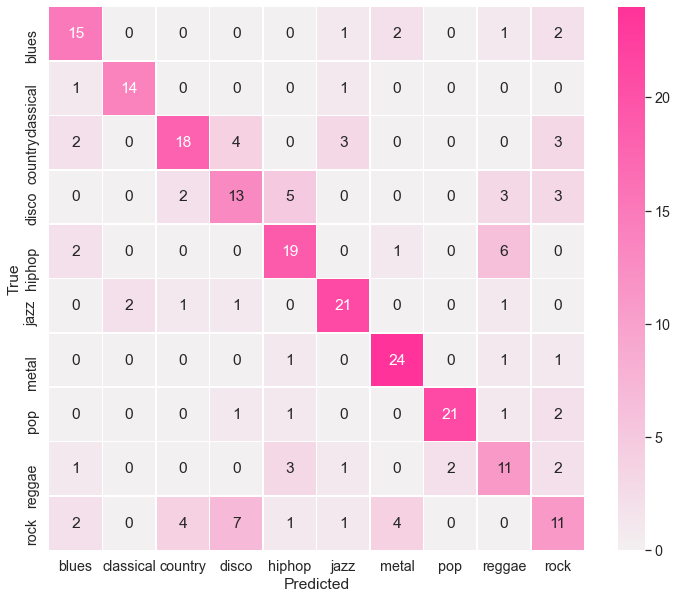

In [59]:
sortedlabels = genre_nums.keys()
cm = pd.DataFrame(cm, index=sortedlabels, columns=sortedlabels)
cm_plot = pd.DataFrame(cm)
sns.set(font_scale=1.3)
sns.heatmap(cm_plot, linewidths=0.5, cmap=sns.light_palette((1, 0.2, 0.6),n_colors=10000), annot=True)
sns.set(rc={'figure.figsize':(12.0,10.0)})
plt.xlabel('Predicted')
plt.ylabel('True')

In [37]:
# Calculate Accuracy Score
acc_score = sklearn.metrics.accuracy_score(y_test, rf_pred)
acc_score

0.8751000800640513

In [38]:
# Print classification report
print(sklearn.metrics.classification_report(y_test, rf_pred))

              precision    recall  f1-score   support

           0       0.87      0.92      0.89       236
           1       0.91      0.97      0.94       247
           2       0.83      0.85      0.84       263
           3       0.82      0.87      0.85       229
           4       0.91      0.84      0.87       262
           5       0.86      0.88      0.87       251
           6       0.90      0.92      0.91       259
           7       0.90      0.86      0.88       242
           8       0.88      0.89      0.89       265
           9       0.87      0.74      0.80       244

    accuracy                           0.88      2498
   macro avg       0.88      0.88      0.87      2498
weighted avg       0.88      0.88      0.87      2498



# RandomForestClassifier for 30 Sec Data

In [39]:
# Separate Features (X) from the Target (y)
y = features_30_df["label"]
X = features_30_df.drop(columns="label", axis=1)

In [40]:
# Drop `filename` (identifier/same as `label`) and `length` (same for all songs - 3 sec sample)
# from features X
X = X.drop(columns=["filename", "length"], axis=1)
X

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,3550.522098,2.977893e+06,...,0.927998,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282
1,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,3805.839606,9.015054e+05,...,0.752740,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035
2,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,3042.260232,7.840345e+05,...,2.451690,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025
3,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,2184.745799,1.493194e+06,...,0.780874,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339
4,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,3579.757627,1.572978e+06,...,-4.520576,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.352063,0.080487,0.079486,0.000345,2008.149458,282174.689224,2106.541053,88609.749506,4253.557033,1.222421e+06,...,1.789867,45.050526,-13.289984,41.754955,2.484145,36.778877,-6.713265,54.866825,-1.193787,49.950665
996,0.398687,0.075086,0.076458,0.000588,2006.843354,182114.709510,2068.942009,82426.016726,4149.338328,1.046621e+06,...,3.739020,33.851742,-10.848309,39.395096,1.881229,32.010040,-7.461491,39.196327,-2.795338,31.773624
997,0.432142,0.075268,0.081651,0.000322,2077.526598,231657.968040,1927.293153,74717.124394,4031.405321,8.042154e+05,...,1.838090,33.597008,-12.845291,36.367264,3.440978,36.001110,-12.588070,42.502201,-2.106337,29.865515
998,0.362485,0.091506,0.083860,0.001211,1398.699344,240318.731073,1818.450280,109090.207161,3015.631004,1.332712e+06,...,-2.812176,46.324894,-4.416050,43.583942,1.556207,34.331261,-5.041897,47.227180,-3.590644,41.299088


In [41]:
# Encode class labels in target y
genre_nums = {}
cnt = 0
for genre in y.unique():
    genre_nums[genre] = cnt
    cnt += 1

y = y.apply(lambda x: genre_nums[x])
genre_nums

{'blues': 0,
 'classical': 1,
 'country': 2,
 'disco': 3,
 'hiphop': 4,
 'jazz': 5,
 'metal': 6,
 'pop': 7,
 'reggae': 8,
 'rock': 9}

In [42]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [43]:
# Instantiate the model
rf_30_model = RandomForestClassifier(n_estimators=500) # CHANGEABLE for bar plot comparisons

# Fit the model
rf_30_model = rf_30_model.fit(X_train, y_train)

# Make predicitions using the testing data
rf_30_pred = rf_30_model.predict(X_test)
results = pd.DataFrame({
    "Prediction": rf_30_pred,
    "Actual": y_test
}).reset_index(drop=True)
results

,Prediction,Actual
0,9,9
1,8,8
2,2,2
3,5,5
4,6,6
...,...,...
245,4,4
246,9,3
247,9,0
248,4,4


In [44]:
# Evaluate model
cm = sklearn.metrics.confusion_matrix(y_test, rf_30_pred)
cm

array([[15,  0,  0,  0,  0,  1,  2,  0,  1,  2],
       [ 1, 14,  0,  0,  0,  1,  0,  0,  0,  0],
       [ 2,  0, 18,  4,  0,  3,  0,  0,  0,  3],
       [ 0,  0,  2, 13,  5,  0,  0,  0,  3,  3],
       [ 2,  0,  0,  0, 19,  0,  1,  0,  6,  0],
       [ 0,  2,  1,  1,  0, 21,  0,  0,  1,  0],
       [ 0,  0,  0,  0,  1,  0, 24,  0,  1,  1],
       [ 0,  0,  0,  1,  1,  0,  0, 21,  1,  2],
       [ 1,  0,  0,  0,  3,  1,  0,  2, 11,  2],
       [ 2,  0,  4,  7,  1,  1,  4,  0,  0, 11]], dtype=int64)

Text(80.5, 0.5, 'True')

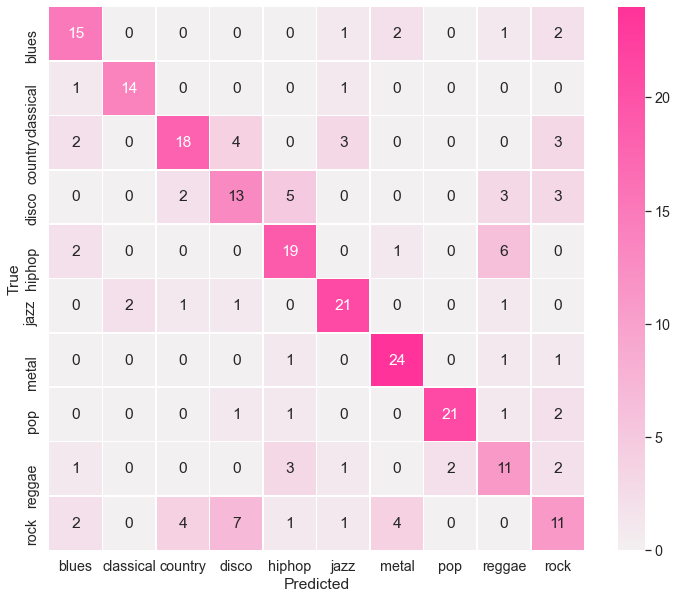

In [45]:
sortedlabels = genre_nums.keys()
cm = pd.DataFrame(cm, index=sortedlabels, columns=sortedlabels)
cm_plot = pd.DataFrame(cm)
sns.set(font_scale=1.3)
sns.heatmap(cm_plot, linewidths=0.5, cmap=sns.light_palette((1, 0.2, 0.6),n_colors=10000), annot=True)
sns.set(rc={'figure.figsize':(12.0,10.0)})
plt.xlabel('Predicted')
plt.ylabel('True')

In [46]:
# Calculate Accuracy Score
acc_score = sklearn.metrics.accuracy_score(y_test, rf_30_pred)
acc_score

0.668

In [47]:
# Print classification report
print(sklearn.metrics.classification_report(y_test, rf_30_pred))

              precision    recall  f1-score   support

           0       0.65      0.71      0.68        21
           1       0.88      0.88      0.88        16
           2       0.72      0.60      0.65        30
           3       0.50      0.50      0.50        26
           4       0.63      0.68      0.66        28
           5       0.75      0.81      0.78        26
           6       0.77      0.89      0.83        27
           7       0.91      0.81      0.86        26
           8       0.46      0.55      0.50        20
           9       0.46      0.37      0.41        30

    accuracy                           0.67       250
   macro avg       0.67      0.68      0.67       250
weighted avg       0.67      0.67      0.67       250



# Build, Train, and Test Neural Network to Predict `label` from Images

In [48]:
X = np.copy(images)
y = np.copy(genres)

In [49]:
y = np.vectorize(genre_nums.get)(y)

In [50]:
# Encode class labels in target y
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,

In [51]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(749, 288, 432)
(250, 288, 432)
(749,)
(250,)


In [52]:
# Normalize pixel data:
X_train = X_train / 255
X_test = X_test / 255

In [53]:
# Define Neural Net
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[288, 432]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")])

In [54]:
# Print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 124416)            0         
_________________________________________________________________
dense (Dense)                (None, 300)               37325100  
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1010      
Total params: 37,376,410
Trainable params: 37,376,410
Non-trainable params: 0
____________________________________________

In [55]:
# Compile model
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])

In [56]:
# Train the model
history = model.fit(X_train, y_train, epochs=200)

Epoch 1/200
24/24 [==============================] - 4s 138ms/step - loss: 2.6673 - accuracy: 0.1133
Epoch 2/200
24/24 [==============================] - 3s 133ms/step - loss: 2.3227 - accuracy: 0.1187
Epoch 3/200
24/24 [==============================] - 3s 130ms/step - loss: 2.3234 - accuracy: 0.1136
Epoch 4/200
24/24 [==============================] - 3s 129ms/step - loss: 2.3063 - accuracy: 0.0861
Epoch 5/200
24/24 [==============================] - 3s 131ms/step - loss: 2.2922 - accuracy: 0.1274
Epoch 6/200
24/24 [==============================] - 3s 128ms/step - loss: 2.2683 - accuracy: 0.1603
Epoch 7/200
24/24 [==============================] - 3s 128ms/step - loss: 2.2786 - accuracy: 0.1250
Epoch 8/200
24/24 [==============================] - 3s 133ms/step - loss: 2.2662 - accuracy: 0.1653
Epoch 9/200
24/24 [==============================] - 3s 129ms/step - loss: 2.2072 - accuracy: 0.1738
Epoch 10/200
24/24 [==============================] - 3s 126ms/step - loss: 2.2380 - accura

24/24 [==============================] - 3s 118ms/step - loss: 1.8011 - accuracy: 0.3179
Epoch 82/200
24/24 [==============================] - 3s 121ms/step - loss: 1.7650 - accuracy: 0.3487
Epoch 83/200
24/24 [==============================] - 3s 114ms/step - loss: 1.8034 - accuracy: 0.3222
Epoch 84/200
24/24 [==============================] - 3s 116ms/step - loss: 1.8375 - accuracy: 0.3094
Epoch 85/200
24/24 [==============================] - 3s 119ms/step - loss: 1.8250 - accuracy: 0.3091
Epoch 86/200
24/24 [==============================] - 3s 120ms/step - loss: 1.8618 - accuracy: 0.2892
Epoch 87/200
24/24 [==============================] - 3s 120ms/step - loss: 1.7894 - accuracy: 0.3085
Epoch 88/200
24/24 [==============================] - 3s 122ms/step - loss: 1.7823 - accuracy: 0.3228
Epoch 89/200
24/24 [==============================] - 3s 123ms/step - loss: 1.8236 - accuracy: 0.3305
Epoch 90/200
24/24 [==============================] - 3s 121ms/step - loss: 1.9058 - accuracy: 

24/24 [==============================] - 3s 115ms/step - loss: 1.6495 - accuracy: 0.3531
Epoch 161/200
24/24 [==============================] - 3s 115ms/step - loss: 1.6089 - accuracy: 0.4277
Epoch 162/200
24/24 [==============================] - 3s 115ms/step - loss: 1.5756 - accuracy: 0.4181
Epoch 163/200
24/24 [==============================] - 3s 114ms/step - loss: 1.6669 - accuracy: 0.3772
Epoch 164/200
24/24 [==============================] - 3s 124ms/step - loss: 1.7759 - accuracy: 0.3498
Epoch 165/200
24/24 [==============================] - 3s 121ms/step - loss: 1.6507 - accuracy: 0.4085
Epoch 166/200
24/24 [==============================] - 3s 118ms/step - loss: 1.6205 - accuracy: 0.3934
Epoch 167/200
24/24 [==============================] - 3s 117ms/step - loss: 1.8014 - accuracy: 0.3299
Epoch 168/200
24/24 [==============================] - 3s 117ms/step - loss: 1.5828 - accuracy: 0.4321
Epoch 169/200
24/24 [==============================] - 3s 115ms/step - loss: 1.7187 - a

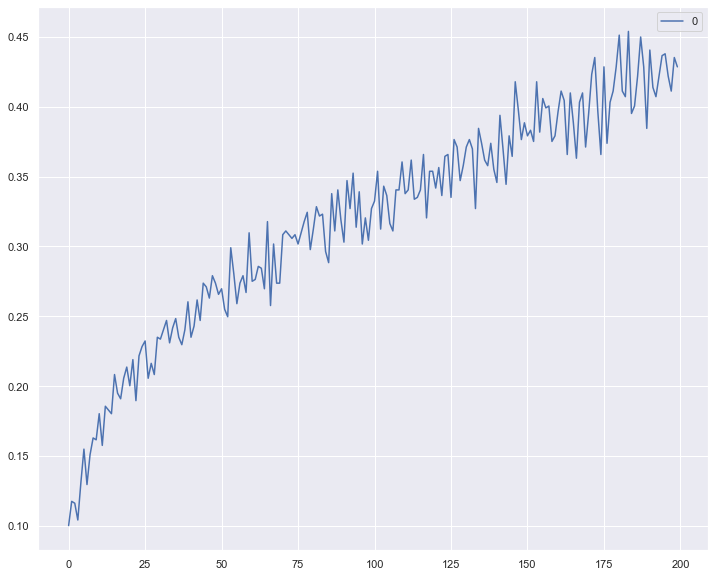

In [57]:
# Plot training results
pd.DataFrame(history.history["accuracy"]).plot()
plt.grid(True)
plt.show()

In [58]:
# Evaluate model
model.evaluate(X_test, y_test)

8/8 [==============================] - 1s 64ms/step - loss: 1.7462 - accuracy: 0.3960


[1.7462087869644165, 0.3959999978542328]